In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def inverse_transform(tensors):
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

In [4]:
class DiffusionHelper:
    def __init__(self, 
                 noise_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02,
                 img_size = 64,
                 device = "cpu"
                 ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta

        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def add_noise(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])[:, None, None, None]
        eps = torch.randn_like(x)
        return sqrt_alpha_hat*x + sqrt_one_minus_alpha_hat*eps, eps
    
    def sample_timesteps(self, n):
        return torch.randint(1, self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            # random image
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

            for i in reversed(range(1, self.noise_steps)):
                t = torch.Tensor([i for x in range(i)]).to(self.device)
                pred_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                noise = torch.rand_like(x) if i > 0 else torch.zeros_like(x)

                x = 1/torch.sqrt(alpha) * (x - ((1-alpha) / (torch.sqrt(1-alpha_hat[t]))) * pred_noise) + torch.sqrt(beta) * noise
        
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x *= 255
        
        return x.type(torch.uint8)

In [5]:
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms

transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(64),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
        ]
    )


dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)

Files already downloaded and verified


In [6]:
dataloader = DataLoader(dataset, batch_size=16, 
                            shuffle=True
                           )
vis_loader = DataLoader(dataset, batch_size=6, 
                            shuffle=True
                           )

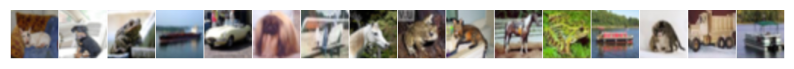

In [7]:
from torchvision.utils import make_grid
 
plt.figure(figsize=(10, 4), facecolor='white')
 
for b_image, _ in dataloader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [8]:
diffusion_helper = DiffusionHelper(img_size=32, device=device)

In [9]:
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

images, labels = next(iter(vis_loader))

for timestep in specific_timesteps:
    timestep = torch.as_tensor([[[timestep]]], dtype=torch.long)

    xts, _ = diffusion_helper.add_noise(images, timestep)
    xts = inverse_transform(xts[:, None, None, None])

    noisy_images.append(xts)

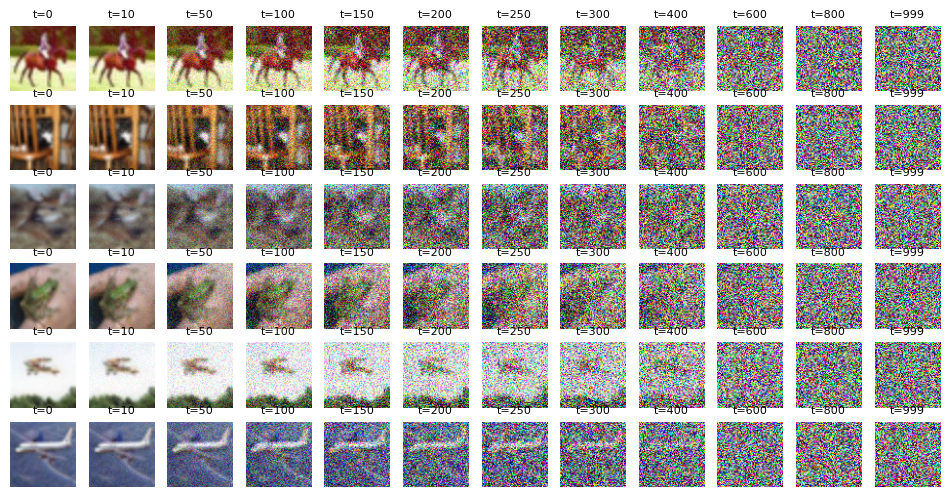

In [10]:
_, ax = plt.subplots(6, len(noisy_images), figsize=(12, 6))
 
for j, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    noisy_sample = torch.squeeze(noisy_sample, dim=(0, 1, 2, 3, 4))
    for i in range(len(noisy_sample)):
        ax[i][j].imshow(noisy_sample[i].permute(1, 2, 0)/255.0)
        ax[i][j].set_title(f"t={timestep}", fontsize=8)
        ax[i][j].axis("off")
        ax[i][j].grid(False)
 
plt.axis("off")
plt.show()

In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cpu"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output


class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [12]:
model = UNet(3, 3).to(device)

In [13]:
EPOCHS = 1
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.05)

for epoch in range(EPOCHS):
    batch = 1
    for x0s, label in dataloader:
        ts = torch.randint(low=1, high=1000, size=(x0s.shape[0],), device=device)
        xts, added_noise = diffusion_helper.add_noise(x0s, ts)

        pred_noise = model(xts, ts)
        
        loss = criterion(added_noise, pred_noise)

        optim.zero_grad()
        loss.backward()
        optim.step()

        print(f"Batch {batch}/{len(dataloader)}")
        batch += 1
        if batch == 5:
            break
    
    samp_images = diffusion_helper.sample(model, x0s.shape[0])

Batch 1/3125
Batch 2/3125
Batch 3/3125


KeyboardInterrupt: 